# MDG1 - Eradicate Extreme Poverty And Hunger 

#### In order to begin our analysis let's review how wealth has grown around the years among the different countries. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

%matplotlib inline

sns.set()

In [3]:
country_metadata = pd.read_csv('data\\GDP_BY_COUNTRY\\Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv')
country_metadata.drop(['IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5'], axis=1, inplace=True)

# Loading historical GDP by country data from World Bank Data(data.worldbank.org)
historical_gdp_by_country = pd.read_csv('data\\GDP_BY_COUNTRY\\API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv', header=2)
historical_gdp_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_gdp_by_country = pd.merge(historical_gdp_by_country, country_metadata, how='left', on=['Country Code'])
historical_gdp_by_country = historical_gdp_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='GDP(US$)')

historical_gdp_by_country['GDP(US$)'] = historical_gdp_by_country['GDP(US$)'].apply(lambda x : x/10**9)
historical_gdp_by_country.rename(columns={'GDP(US$)': 'GDP(US$ in Billions)'}, inplace=True)


# Loading historical Population by country data from World Bank(data.worldbank.org)
historical_pop_by_country = pd.read_csv('data\\POP_BY_COUNTRY\\API_SP.POP.TOTL_DS2_en_csv_v2_10515200.csv', header=2)
historical_pop_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_pop_by_country = pd.merge(historical_pop_by_country, country_metadata, how='left', on=['Country Code'])
historical_pop_by_country = historical_pop_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='Pop(in millions)')

historical_pop_by_country = historical_pop_by_country[(historical_pop_by_country['Pop(in millions)'] != 'SP.POP.TOTL') & (historical_pop_by_country['Pop(in millions)'] != 'Population, total')]
historical_pop_by_country['Pop(in millions)'].astype(np.float64, copy=False)
historical_pop_by_country['Pop(in millions)'] = historical_pop_by_country['Pop(in millions)'].apply(lambda x : x/10**6)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
historical_gdp_by_region = historical_gdp_by_country.groupby(by=['Region','Year'], as_index=False).agg({'GDP(US$ in Billions)': 'sum'})
historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['GDP(US$ in Billions)'] > 0]

historical_pop_by_region = historical_pop_by_country.groupby(by=['Region', 'Year'], as_index=False).agg({'Pop(in millions)': 'sum'})
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Pop(in millions)'] > 0]

historical_gdp_per_capita_by_region = historical_gdp_by_region[['Region', 'Year']]
historical_gdp_per_capita_by_region['GDP Per Capita (per US$1.000,00)'] = historical_gdp_by_region['GDP(US$ in Billions)']*(10**3)/historical_pop_by_region['Pop(in millions)']

## Brief Economical Evaluation

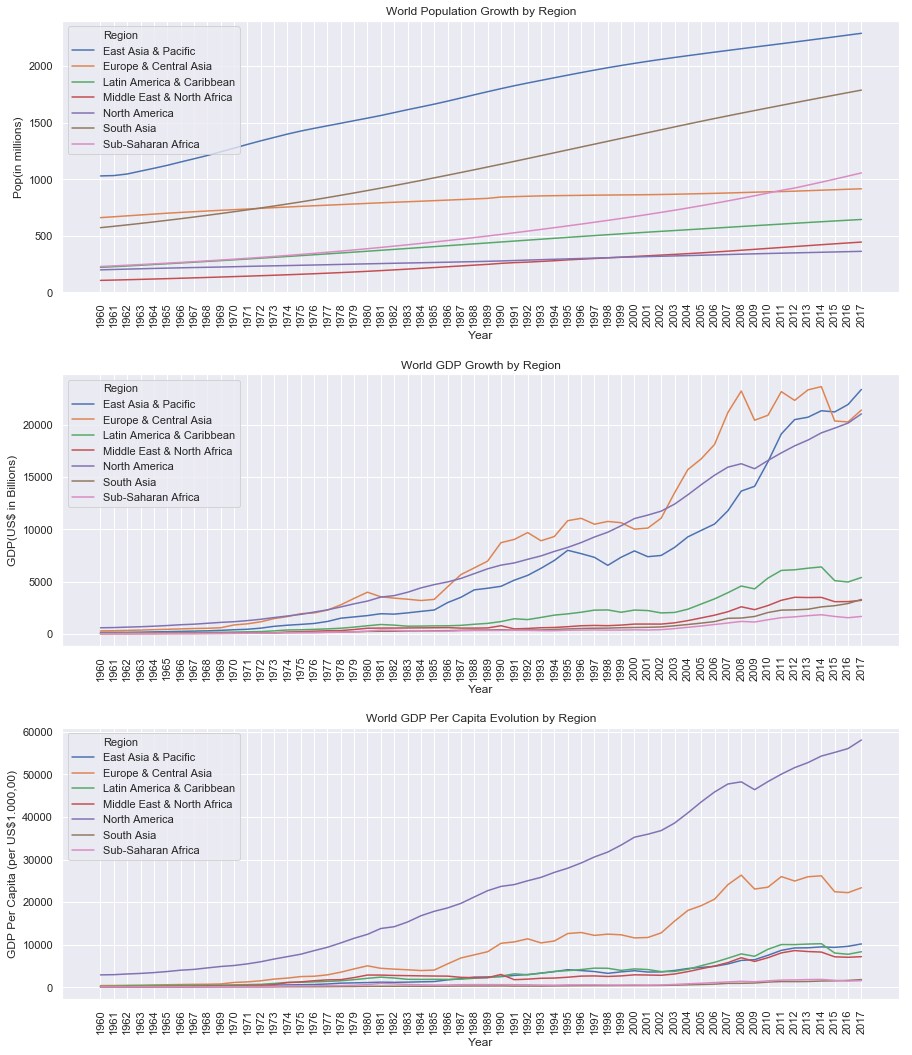

In [5]:
fig,ax = plt.subplots(nrows=3, figsize=(15,18))
titles = ['World Population Growth by Region', 'World GDP Growth by Region', 'World GDP Per Capita Evolution by Region']
for i in range(3):
    plt.sca(ax[i])
    plt.title(titles[i])
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.3)

sns.lineplot(x='Year', y='Pop(in millions)', hue='Region', data=historical_pop_by_region, ax=ax[0])
sns.lineplot(x='Year', y='GDP(US$ in Billions)', hue='Region', data=historical_gdp_by_region, ax=ax[1])
sns.lineplot(x='Year', y='GDP Per Capita (per US$1.000,00)', hue='Region', data=historical_gdp_per_capita_by_region, ax=ax[2])

#### Sub-Saharan Africa and South Asia are clearly the regions that need most assistance when it comes to eradicating poverty. 
#### So they should be the ones we look first to understand what environmental, social and cultural conditions inhibits development on these countries

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [7]:
init_notebook_mode(connected=True)

In [8]:
# Filter regions Sub-Saharan Africa and South Asia
critical_regions_gdp_by_country = historical_gdp_by_country[(historical_gdp_by_country['Region']=='South Asia') | (historical_gdp_by_country['Region']=='Sub-Saharan Africa')]
critical_regions_pop_by_country = historical_pop_by_country[(historical_pop_by_country['Region']=='South Asia') | (historical_pop_by_country['Region']=='Sub-Saharan Africa')]
#critical_regions_gdp_by_country = historical_gdp_by_country[(historical_gdp_by_country['Region']=='Sub-Saharan Africa')]
#critical_regions_pop_by_country = historical_pop_by_country[(historical_pop_by_country['Region']=='Sub-Saharan Africa')]


# Filter last year observation
critical_regions_gdp_by_country = critical_regions_gdp_by_country[critical_regions_gdp_by_country['Year']=='2017']
critical_regions_pop_by_country = critical_regions_pop_by_country[critical_regions_pop_by_country['Year']=='2017']

critical_regions_gdp_pop_by_country = pd.merge(critical_regions_gdp_by_country, critical_regions_pop_by_country, how='inner', on=['Country Name', 'Country Code','Region', 'Year'])
critical_regions_gdp_pop_by_country['GDP Per Capita (per US$1.000,00)'] = critical_regions_gdp_pop_by_country.apply(lambda x : x['GDP(US$ in Billions)']/x['Pop(in millions)'], axis=1)

In [9]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=critical_regions_gdp_pop_by_country['Country Code'],
            text=critical_regions_gdp_pop_by_country['Country Name'],
            z=critical_regions_gdp_pop_by_country['GDP Per Capita (per US$1.000,00)'],
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP per capita (in US$1.000,00)'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2017 Sub-Saharan Africa GDP per capita'
            ),
            geo = go.layout.Geo(
                scope='africa',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [10]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=critical_regions_gdp_pop_by_country['Country Code'],
            text=critical_regions_gdp_pop_by_country['Country Name'],
            z=critical_regions_gdp_pop_by_country['GDP Per Capita (per US$1.000,00)'],
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP per capita (in US$1.000,00)'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2017 South Asia GDP per capita'
            ),
            geo = go.layout.Geo(
                scope='asia',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)


## Analyzing Deeper Economical Factors

#### Now, we will start digging deeper into factors that might inhibit development. 
#### In this section, we look at environmental, social and cultural factors that might keep a nation from thriving economically. 

In [41]:
social_env_cultural_by_country = pd.read_csv('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\API_19_DS2_en_csv_v2_10515758.csv', header=2)
social_env_cultural_by_country = pd.merge(social_env_cultural_by_country, country_metadata, how='left', on=['Country Code'])
social_env_cultural_by_country.drop(['Indicator Name','Unnamed: 63'], axis=1, inplace=True)

# Tidying data
social_env_cultural_by_country = pd.melt(social_env_cultural_by_country, id_vars=['Country Name', 'Country Code', 'Region', 'Indicator Code'], var_name='Year', value_name='observation')
social_env_cultural_by_country = pd.pivot_table(social_env_cultural_by_country, columns=['Indicator Code'], index=['Country Name', 'Country Code', 'Region', 'Year'], values='observation', aggfunc=np.mean)
social_env_cultural_by_country.reset_index(inplace=True)

# Limiting data for the last 30 years
social_env_cultural_by_country = social_env_cultural_by_country[social_env_cultural_by_country['Year'] >= '1980']

# Selecting criteria among csv file and grouping them by topic
standard_columns = ['Country Name', 'Country Code', 'Region', 'Year']
health_metrics = ['SH.STA.MALN.ZS','SH.MED.CMHW.P3','SH.DYN.MORT']
climate_metrics = ['AG.LND.PRCP.MM','EN.CLC.MDAT.ZS']
land_metrics = ['AG.LND.ARBL.ZS','AG.LND.IRIG.AG.ZS','NV.AGR.TOTL.ZS','AG.YLD.CREL.KG'] 
social_metrics = ['SI.POV.DDAY','EG.ELC.ACCS.ZS']
cultural_metrics = ['IC.BUS.EASE.XQ']


# Grouping data by Region and Year and applying mean to all observation columns 
health_metrics_by_country = social_env_cultural_by_country.loc[:, standard_columns + health_metrics]
climate_metrics_by_country = social_env_cultural_by_country.loc[:, standard_columns + climate_metrics]
land_metrics_by_country = social_env_cultural_by_country.loc[:, standard_columns + land_metrics]
social_metrics_by_country = social_env_cultural_by_country.loc[:, standard_columns + social_metrics]
cultural_metrics_by_country = social_env_cultural_by_country.loc[:, standard_columns + cultural_metrics]

# Renaming observation columns
health_metrics_by_country.rename(columns={'SH.STA.MALN.ZS': '% Underweight Under 5','SH.MED.CMHW.P3': 'Health Workers(per 1.000 people)','SH.DYN.MORT': 'Mortality Rate Under 5(per 1.000 births)'}, inplace=True)
climate_metrics_by_country.rename(columns={'AG.LND.PRCP.MM': 'Avg precipitation(mm)','EN.CLC.MDAT.ZS': '% Pop affected by extreme conditions(Droughts, Flood, high temps)'}, inplace=True)
land_metrics_by_country.rename(columns={'AG.LND.ARBL.ZS': '% Arable Land','AG.LND.IRIG.AG.ZS': '% Agric. Irrigated Land','NV.AGR.TOTL.ZS': 'Agric., Florestry and Fishing(% of GDP)','AG.YLD.CREL.KG': 'Cereal Yield(Kg/hectare)'}, inplace=True)
social_metrics_by_country.rename(columns={'SI.POV.DDAY': 'Extreme Poverty(% pop)','EG.ELC.ACCS.ZS': 'Access Electricity(% pop)'}, inplace=True)
cultural_metrics_by_country.rename(columns={'IC.BUS.EASE.XQ': 'Ease of Doing Business'}, inplace=True)

In [42]:
health_metrics_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8431 entries, 20 to 12749
Data columns (total 7 columns):
Country Name                                8431 non-null object
Country Code                                8431 non-null object
Region                                      8431 non-null object
Year                                        8431 non-null object
% Underweight Under 5                       821 non-null float64
Health Workers(per 1.000 people)            198 non-null float64
Mortality Rate Under 5(per 1.000 births)    7253 non-null float64
dtypes: float64(3), object(4)
memory usage: 526.9+ KB


In [43]:
climate_metrics_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8431 entries, 20 to 12749
Data columns (total 6 columns):
Country Name                                                         8431 non-null object
Country Code                                                         8431 non-null object
Region                                                               8431 non-null object
Year                                                                 8431 non-null object
Avg precipitation(mm)                                                1444 non-null float64
% Pop affected by extreme conditions(Droughts, Flood, high temps)    168 non-null float64
dtypes: float64(2), object(4)
memory usage: 461.1+ KB


In [44]:
land_metrics_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8431 entries, 20 to 12749
Data columns (total 8 columns):
Country Name                               8431 non-null object
Country Code                               8431 non-null object
Region                                     8431 non-null object
Year                                       8431 non-null object
% Arable Land                              7201 non-null float64
% Agric. Irrigated Land                    856 non-null float64
Agric., Florestry and Fishing(% of GDP)    6104 non-null float64
Cereal Yield(Kg/hectare)                   6188 non-null float64
dtypes: float64(4), object(4)
memory usage: 592.8+ KB


In [45]:
social_metrics_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8431 entries, 20 to 12749
Data columns (total 6 columns):
Country Name                 8431 non-null object
Country Code                 8431 non-null object
Region                       8431 non-null object
Year                         8431 non-null object
Extreme Poverty(% pop)       1489 non-null float64
Access Electricity(% pop)    5716 non-null float64
dtypes: float64(2), object(4)
memory usage: 461.1+ KB


In [18]:
cultural_metrics_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 52 to 12749
Data columns (total 5 columns):
Country Name              1491 non-null object
Country Code              1491 non-null object
Region                    1491 non-null object
Year                      1491 non-null object
Ease of Doing Business    189 non-null float64
dtypes: float64(1), object(4)
memory usage: 69.9+ KB


In [51]:
health_metrics_by_country_2017 = health_metrics_by_country[health_metrics_by_country['Year'] == '1989']

In [52]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=health_metrics_by_country_2017['Country Code'],
            text=health_metrics_by_country_2017['Country Name'],
            z=health_metrics_by_country_2017['Mortality Rate Under 5(per 1.000 births)']/10,
            colorbar = {'title':'Mortality Rate Under 5 years old',
                        'ticksuffix': '%'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2017 World Mortality Rate Under 5'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [46]:
social_metrics_by_country_2016 = social_metrics_by_country[social_metrics_by_country['Year'] == '2000']

In [47]:
social_metrics_by_country_2016

Indicator Code,Country Name,Country Code,Region,Year,Extreme Poverty(% pop),Access Electricity(% pop)
40,Afghanistan,AFG,South Asia,2000,NaN,0.959756
99,Albania,ALB,Europe & Central Asia,2000,NaN,100.000000
158,Algeria,DZA,Middle East & North Africa,2000,NaN,98.965157
217,American Samoa,ASM,East Asia & Pacific,2000,NaN,NaN
275,Andorra,AND,Europe & Central Asia,2000,NaN,100.000000
333,Angola,AGO,Sub-Saharan Africa,2000,32.3,22.843355
392,Antigua and Barbuda,ATG,Latin America & Caribbean,2000,NaN,90.072083
451,Argentina,ARG,Latin America & Caribbean,2000,5.7,95.099205
510,Armenia,ARM,Europe & Central Asia,2000,NaN,98.900000
569,Aruba,ABW,Latin America & Caribbean,2000,NaN,91.660398


In [48]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=social_metrics_by_country_2016['Country Code'],
            text=social_metrics_by_country_2016['Country Name'],
            z=social_metrics_by_country_2016['Access Electricity(% pop)'],
            colorbar = {'title':'Access to Electricity',
                        'ticksuffix': '%'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2016 - Access to Electricity (% of pop)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)